In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import sqlalchemy


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'Salaries' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'Salaries' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the date and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter((Measurement.date) >= date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['Date', 'Precipitation'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'], format='%Y-%m-%d')
prcp_df = prcp_df.sort_values(by='Date')
prcp_df = prcp_df.dropna()
prcp_df

,Date,Precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


<AxesSubplot:>

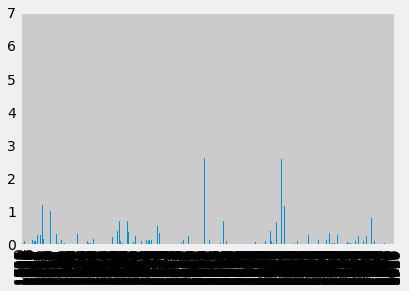

In [14]:
prcp_bar = prcp_df['Precipitation'].plot.bar
prcp_bar()

In [19]:
monthly_prcp_df = prcp_df.groupby(pd.Grouper(key='Date', freq="M")).mean()
monthly_prcp_df = monthly_prcp_df.rename(columns={"Precipitation": "Average Monthly Precipitation"})

monthly_prcp_df

,Average Monthly Precipitation
Date,
2016-08-31,0.392642
2016-09-30,0.285549
2016-10-31,0.121620
2016-11-30,0.120234
2016-12-31,0.199494
2017-01-31,0.070294
2017-02-28,0.241111
2017-03-31,0.175266
2017-04-30,0.321111


<AxesSubplot:xlabel='Date'>

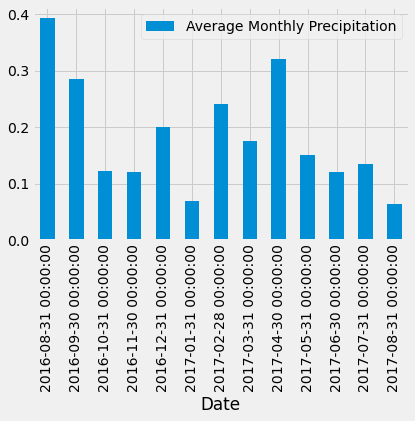

In [20]:
monthly_prcp_bar = monthly_prcp_df.plot.bar
monthly_prcp_bar()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# df.describe()
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
station_groupby = session.query(Measurement.station).group_by(Measurement.station)
total_stations = station_groupby.count()
total_stations

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(Measurement.station.desc()).all()
station_count
station_df = pd.DataFrame(station_count, columns=['Station ID', 'Station Activity'])
station_df = station_df.sort_values(by=['Station Activity'], ascending=False)  
station_df

,Station ID,Station Activity
2,USC00519281,2772
1,USC00519397,2724
7,USC00513117,2709
0,USC00519523,2669
5,USC00516128,2612
6,USC00514830,2202
8,USC00511918,1979
4,USC00517948,1372
3,USC00518838,511


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


ast = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter((Measurement.station) == 'USC00519281').all()
ast_df = pd.DataFrame(ast, columns=['Station ID', 'Min Temp','Max Temp', 'Avg Temp'])
ast_df = ast_df.set_index('Station ID')
ast_df

,Min Temp,Max Temp,Avg Temp
Station ID,,,
USC00519281,54.0,85.0,71.663781


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ast12 = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter((Measurement.station) == 'USC00519281', (Measurement.date)>=date).all()
ast12_df = pd.DataFrame(ast12, columns=['Station ID', 'Date','TOBS'])

ast12_df

,Station ID,Date,TOBS
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


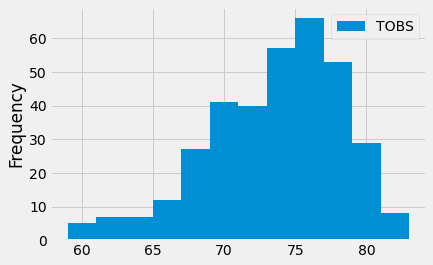

In [26]:
ast12_df.plot.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2017-01-01'))

[(53.0, 73.34760498687665, 86.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
